# <font color='White'>Table of contents<font><a class='anchor' id='top'></a>
- [Pre Processing](#1)
- [Question 1 - PCA](#2)
- [Question 2 - Reconstructed Images](#3)
- [Question 3 - Scatter Plot of Rock Images](#4)
- [Question 4 - Comparing to Human Data](#4)
- [Question 5 - Kmeans Clustering](#6)|
- [Question 6 - Expectation Maximization](#7)
- [Question 7 - Convulutional Neural Network](#8)

#### Imports

In [1]:

# Data Processing
import numpy as np
import pandas as pd

# ML models
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

# Dimension Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE, LocallyLinearEmbedding

# Statistics
from scipy.spatial import procrustes
from scipy.stats import pearsonr

# Visualization
import matplotlib.pyplot as plt

# Image processing
from PIL import Image, ImageOps
import os
import cv2

# misc 
import time
import warnings
warnings.filterwarnings("ignore")


#### Nice Visualizations

In [2]:

plt.rc('font', family='Serif', size=12)  
plt.rc('axes', titlesize=14, titleweight='bold')
plt.rc('axes', labelsize=12, titlesize=14)
plt.rc('legend', fontsize=10)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

#### Global Variables and file paths


In [3]:
RANDOM_STATE = 99
COLOR_MAP = plt.cm.twilight
IMAGE_FOLDER = "Data/Rock_Images"
VALIDATION_FOLDER = "Data/Validation_Images"
HUMAN_PREDICTIVE_FEATURES = "Data/mds_360.txt"

<a id="1"></a>
### Pre Processing
Load the rock images

In [78]:
def get_label_from_filename(filename):
    if filename.startswith('I'):
        return 'Igneous'
    elif filename.startswith('M'):
        return 'Metamorphic'
    else:
        return 'Sedimentary'

def load_images_to_dataframe(folder):
    data = []  # To store flattened image data
    filenames = []  # To store filenames
    labels = []  # To store labels
    
    for filename in os.listdir(folder):
        if filename.endswith(".jpg"):  # Process only .jpg files
            # Assign label
            label = get_label_from_filename(filename)
            labels.append(label)

            # Load and preprocess image
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path)
            img = ImageOps.grayscale(img)
            img = img.resize((256, 256))
            img_array = np.array(img) / 255.0  
            
            # Flatten and append data
            data.append(img_array.flatten())
            filenames.append(filename)
    
    # Create DataFrame with image data
    image_df = pd.DataFrame(data, columns=list(range(len(data[0]))))
    
    # image_df['filename'] = filenames
    # image_df['label'] = labels  
    
    return image_df, pd.Series(labels)

In [79]:
DATA, LABELS = load_images_to_dataframe(IMAGE_FOLDER)

rock_mapping = {"Igneous": 0, "Metamorphic": 1, "Sedimentary": 2}
encoded_labels = LABELS.map(rock_mapping)

Total Number of Rocks

In [6]:
len(DATA)

360

In [75]:
print(encoded_labels)

0      0
1      1
2      2
3      0
4      1
      ..
355    2
356    1
357    1
358    1
359    2
Length: 360, dtype: int64


The total number of features after converting to grayscale, resizing and flatenning image is 65536.

In [7]:
len(DATA.columns)

65536

In [8]:
print(DATA.shape)

(360, 65536)


In [9]:
DATA.head()

,0,1,2,3,4,5,6,7,8,9,...,65526,65527,65528,65529,65530,65531,65532,65533,65534,65535
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


<a id="2"></a>
## Queston 1
Apply PCA to the images from folder '360 Rocks'. How many components do you need to preserve 90% of the variance?


In [10]:
pca = PCA(n_components = 0.9, svd_solver = "full")
X_reduced = pca.fit_transform(DATA)
X_recovered = pca.inverse_transform(X_reduced)

In [11]:
print("Length of reduced vector to preserve 90% variance: ", len(X_reduced[0]))

Length of reduced vector to preserve 90% variance:  141


Number of components required to preserve 90% variance: 141


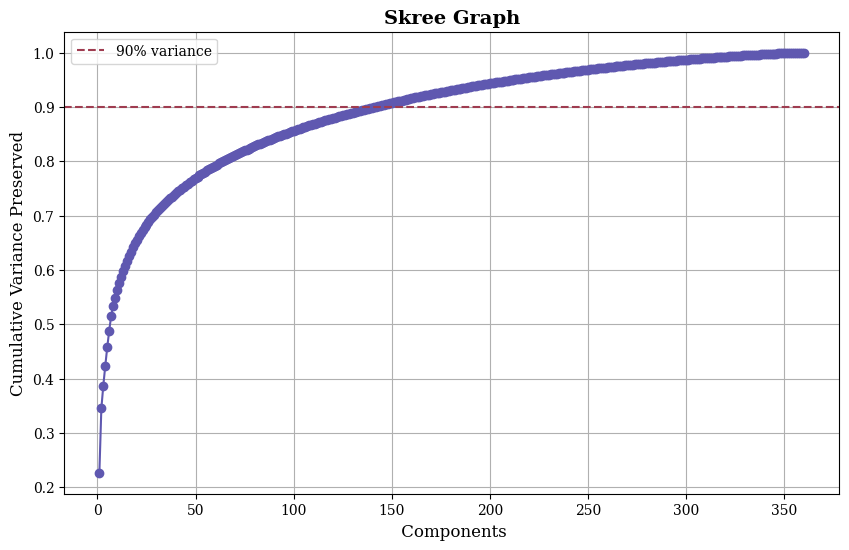

In [12]:
# Getting cumulative variance preserved for every feature included in the PCA.
line_color = COLOR_MAP(.3)
hline_color = COLOR_MAP(.7)

pca = PCA(svd_solver = "full")
pca.fit(DATA)
cumulative_variance = pca.explained_variance_ratio_.cumsum()
n_components_90 = (cumulative_variance >= 0.90).argmax() + 1

print(f"Number of components required to preserve 90% variance: {n_components_90}")
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color=line_color)
plt.xlabel(' Components')
plt.ylabel('Cumulative Variance Preserved')
plt.title('Skree Graph')
plt.axhline(y=0.90, color='r', linestyle='--', label="90% variance", c=hline_color)
plt.legend()
plt.grid(True)
plt.show()


<a id="3"></a>
## Question 2
Plot 10 images of your choice in the original form (without PCA) and then plot their reconstruction (projection in the original space) after you kept 90% of variance using PCA

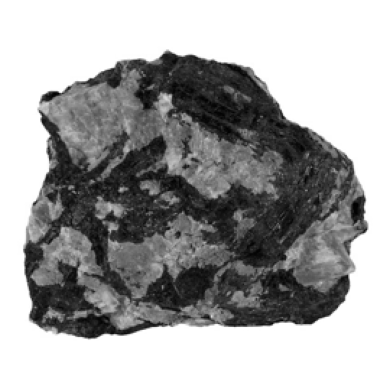

In [13]:
plt.imshow(np.array(DATA.iloc[0, : ]).reshape((256, 256)), cmap = 'grey')
plt.axis('off')
plt.show()

In [14]:
pca = PCA(n_components = 0.9, svd_solver = "full")
X_reduced = pca.fit_transform(DATA)
X_recovered = pca.inverse_transform(X_reduced)

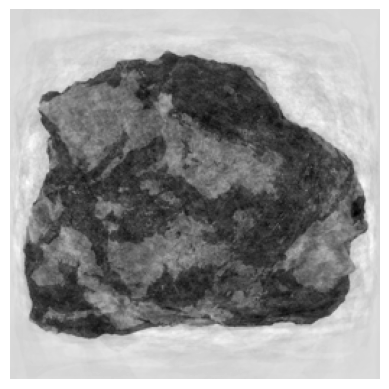

In [15]:
plt.imshow(X_recovered[0].reshape((256, 256)), cmap = "grey")
plt.axis('off')
plt.show()

<Figure size 1000x1500 with 0 Axes>

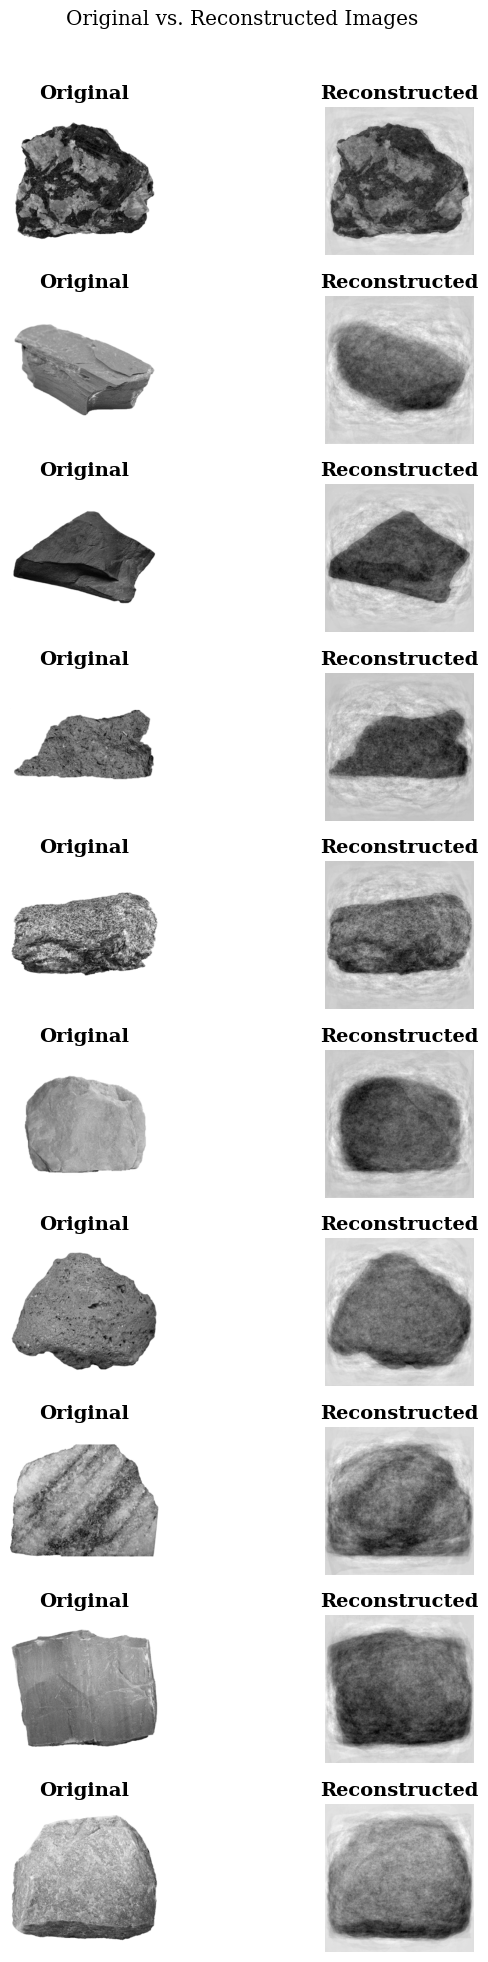

In [16]:
# Plotting the images pre and post reconstruction side by side:

num_images = 10
sample_indices = range(num_images)

plt.figure(figsize = (10, 15))

fig, axes = plt.subplots(num_images, 2, figsize=(8, num_images * 2))

for i, idx in enumerate(sample_indices):
    axes[i, 0].imshow(np.array(DATA.iloc[idx, : ]).reshape((256, 256)), cmap='gray')
    axes[i, 0].set_title("Original")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(X_recovered[idx].reshape((256, 256)), cmap='gray')
    axes[i, 1].set_title("Reconstructed")
    axes[i, 1].axis('off')

plt.suptitle("Original vs. Reconstructed Images")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

<a id="4"></a>
## Question 3
Each of the images belongs to one of three rock categories. The category is indicated by the first letter in the filename (I, M and S). We will now try to see if the visualization can help us identify different clusters

#### 3.A
Use PCA to reduce dimensionality to only 2 dimensions. How much of the variance is explained with the first two principal components?

In [17]:
pca_two = PCA(n_components = 2)
X_reduced_two = pca_two.fit_transform(DATA)
X_recovered_two = pca_two.inverse_transform(X_reduced_two)

In [18]:
pca_two.explained_variance_ratio_

array([0.22656558, 0.11828768])

In [19]:
print("Total variance explained by the first two components: ", sum(pca_two.explained_variance_ratio_))

Total variance explained by the first two components:  0.3448532671987319


In [20]:
plot_data = pd.DataFrame(columns = ["PC1", "PC2", "Label"])

for itr in range(len(X_reduced_two)):
  curr_row = [X_reduced_two[itr][0], X_reduced_two[itr][1], LABELS[itr]]
  plot_data.loc[len(plot_data)] = curr_row

In [21]:
plot_data

,PC1,PC2,Label
0,-39.453101,2.372262,Igneous
1,35.090716,3.852767,Metamorphic
2,13.837510,28.623222,Sedimentary
3,34.313488,13.168418,Igneous
4,19.207317,16.501437,Metamorphic
...,...,...,...
355,31.650672,1.835759,Sedimentary
356,-21.260694,-1.349516,Metamorphic
357,35.674853,8.754495,Metamorphic
358,36.363355,-30.216397,Metamorphic


#### 3.B

Plot a 2D scatter plot of the images spanned by the first two principal components. Each image will be represented with a dot. Make the color of the dot correspond to the image category (so you will have three different colors). Then add some rock images to the visualization to better understand what features in the images are accounting for the majority of variance in the data (your visualization should look similar to the one after line 71 in this file https://github.com/ageron/handson-ml3/blob/main/08_dimensionality_reduction.ipynbLinks to an external site. but with images of rocks instead of MNIST digits). Repeat the process and create the same type of plots for t-SNE, LLE and MDS. [6 points]

In [22]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.04, images=None, figsize=(13, 10), method=None):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    plt.title(method)
    plt.legend()
    
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1],
                    c=[COLOR_MAP(float(digit) / 9)], alpha=0.5)
    plt.axis("off")
    ax = plt.gca()  # get current axes
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=COLOR_MAP(float(y[index]) / 9),
                         fontdict={"weight": "bold", "size": 16})
            else:
                image = np.array(images.iloc[index, : ]).reshape((256, 256))
                image = cv2.resize(image, (28, 28))
                imagebox = AnnotationBbox(OffsetImage(image, cmap='grey'),
                                          image_coord, frameon=False, arrowprops=dict(arrowstyle="->"))
                ax.add_artist(imagebox)


def plot_principle_components(Reduced_X, method):
    print("Total variance explained by the first two components: ", sum(pca_two.explained_variance_ratio_))

    plot_data = pd.DataFrame(
        {
            "PC1": Reduced_X[:, 0],  
            "PC2": Reduced_X[:, 1],  
            "Label": LABELS              
        }
    )

    # Plot data
    plot_digits(
        plot_data[["PC1", "PC2"]],  
        encoded_labels,                
        images=DATA,               
        figsize=(10, 10),
        method = method            
    )

Total variance explained by the first two components:  0.3448532671987321


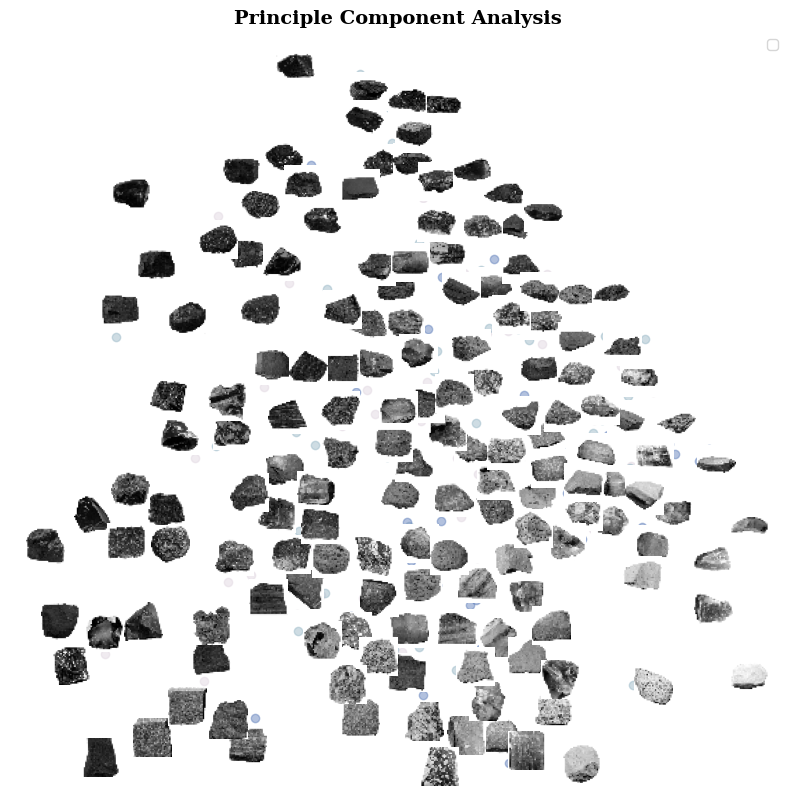

In [23]:
pca_two = PCA(n_components = 2)
Reduced_X = pca_two.fit_transform(DATA)
method = 'Principle Component Analysis'
plot_principle_components(Reduced_X, method)


Total variance explained by the first two components:  0.3448532671987321


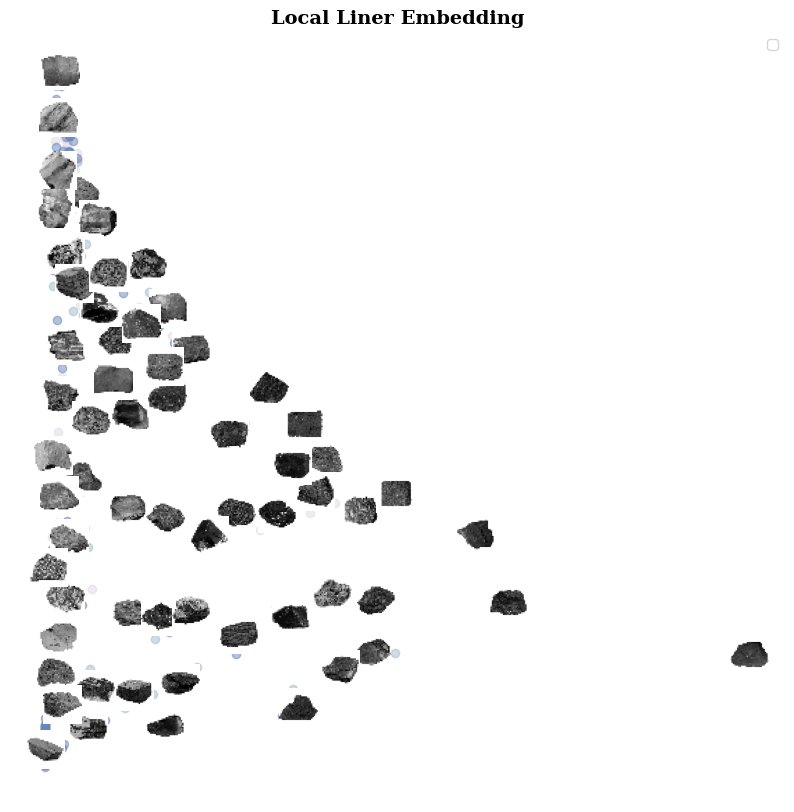

In [24]:

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=5) 
Reduced_X = lle.fit_transform(DATA)
method = 'Local Liner Embedding'
plot_principle_components(Reduced_X, method)

Total variance explained by the first two components:  0.34485326719873133


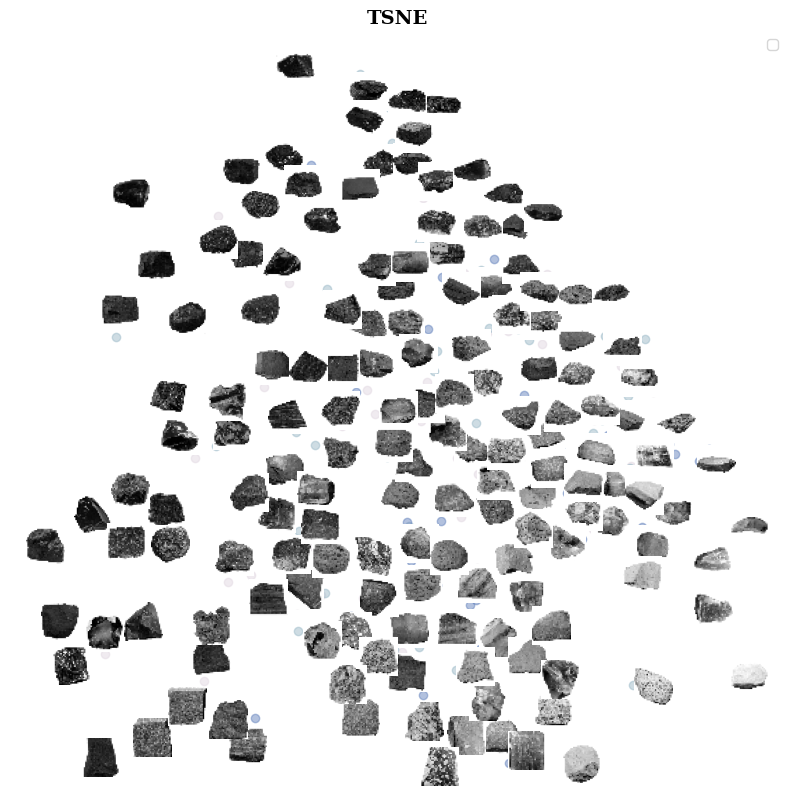

In [25]:

tsne = TSNE(n_components=2, perplexity=1, random_state=0)  
Reduced_X = pca_two.fit_transform(DATA)
method = 'TSNE'
plot_principle_components(Reduced_X, method)


Total variance explained by the first two components:  0.34485326719873133


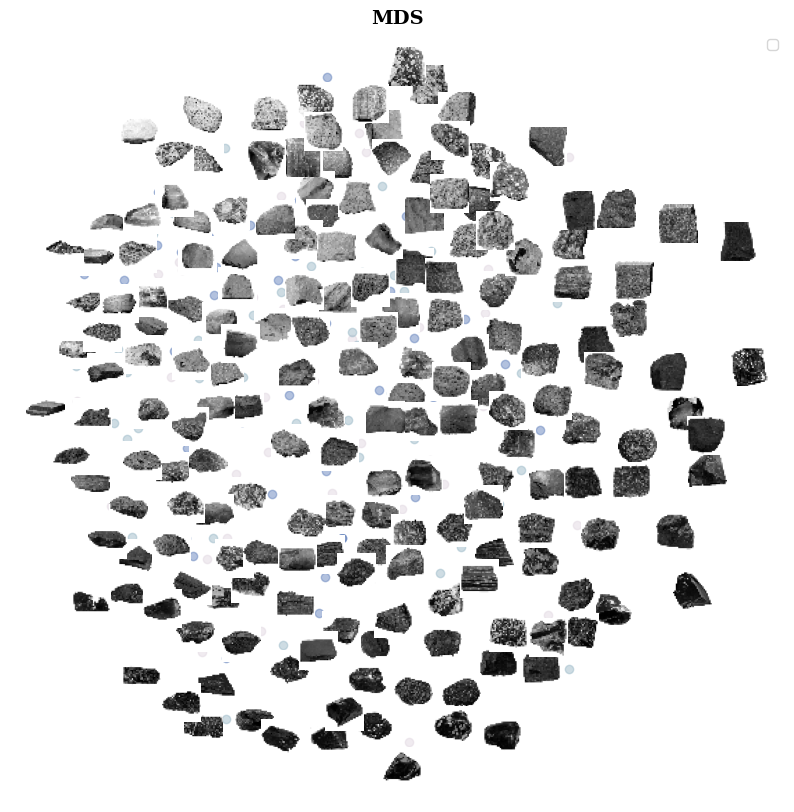

In [26]:

mds = MDS(n_components=2, random_state=0) 
Reduced_X = mds.fit_transform(DATA)
method = 'MDS'
plot_principle_components(Reduced_X, method)


<a id="5"></a>
## Question 4 

Now let's see if these dimensionality reduction techniques can give us similar features to those that humans use to judge the images. File mds_360.txt contains 8 features for each of the images (rankings are in the same order as the images in  '360 Rocks' folder. Run PCA, LLE and MDS to reduce the dimensionality of the images to 8.

In [27]:
matrix_with_human_data = np.loadtxt(HUMAN_PREDICTIVE_FEATURES)
print(matrix_with_human_data)
print("Shape of Most important features for humans", matrix_with_human_data.shape)


procrustes_analysis = []

[[-3.743 -1.204  2.001 ... -1.992  4.95   1.695]
 [ 2.332  1.625  0.985 ...  0.093  6.724  0.708]
 [ 0.346  1.49  -3.795 ... -3.786  0.706 -2.854]
 ...
 [-3.475 -3.431 -2.184 ... -2.265  1.129 -1.201]
 [-0.051 -2.358  1.994 ...  7.268 -0.593 -1.432]
 [ 1.134 -4.9    0.983 ...  4.695  0.624 -1.195]]
Shape of Most important features for humans (360, 8)


#### PCA

In [28]:
mds = PCA(n_components=8, random_state=RANDOM_STATE)
matrix_with_pca_embeddings_data = mds.fit_transform(DATA)
mtx1, mtx2, disparity = procrustes(matrix_with_human_data, matrix_with_pca_embeddings_data)
stat, p_value = pearsonr(mtx1.ravel(), mtx2.ravel())

pca_result = {
        'Embedding': 'PCA',
        'Disparity': disparity,
        'Correlation': stat,
        'P_Value': p_value
}

procrustes_analysis.append(pca_result)

print('Embedding: PCA')
print(f'Disparity: {disparity}')
print(f'Correlation: {stat}')
print(f'P_value: {p_value}')

Embedding: PCA
Disparity: 0.9882898436851537
Correlation: 0.1082134756619817
P_value: 5.817315253326653e-09


#### LLE

In [29]:
lle = LocallyLinearEmbedding(n_components=8, n_neighbors=10) 
matrix_with_lle_embeddings_data = lle.fit_transform(DATA)
mtx1, mtx2, disparity = procrustes(matrix_with_human_data, matrix_with_lle_embeddings_data)
stat, p_value = pearsonr(mtx1.ravel(), mtx2.ravel())
lle_result = {
        'Embedding': 'LLE',
        'Disparity': disparity,
        'Correlation': stat,
        'P_Value': p_value
}

procrustes_analysis.append(lle_result)

print('Embedding: LLE')
print(f'Disparity: {disparity}')
print(f'Correlation: {stat}')
print(f'P_value: {p_value}')

Embedding: LLE
Disparity: 0.9836376725777465
Correlation: 0.12791531347830715
P_value: 5.5793707487475366e-12


#### MDS

In [30]:
mds = MDS(n_components=8, random_state=RANDOM_STATE)
matrix_with_mds_embeddings_data = mds.fit_transform(DATA)
mtx1, mtx2, disparity = procrustes(matrix_with_human_data, matrix_with_mds_embeddings_data)
stat, p_value = pearsonr(mtx1.ravel(), mtx2.ravel())

mds_result = {
        'Embedding': 'MDS',
        'Disparity': disparity,
        'Correlation': stat,
        'P_Value': p_value
}

procrustes_analysis.append(mds_result)

print('Embedding: MDS')
print(f'Disparity: {disparity}')
print(f'Correlation: {stat}')
print(f'P_value: {p_value}')

Embedding: MDS
Disparity: 0.9879922010282565
Correlation: 0.10958010299202886
P_value: 3.726567678639763e-09


In [31]:
human_comparison_df = pd.DataFrame(procrustes_analysis).sort_values(by='Disparity')
display(human_comparison_df)

,Embedding,Disparity,Correlation,P_Value
1,LLE,0.983638,0.127915,5.579371e-12
2,MDS,0.987992,0.109580,3.726568e-09
0,PCA,0.988290,0.108213,5.817315e-09


<a id="6"></a>
## Question 5

Cluster the 360 images using K-Means

In [32]:
pca = PCA(n_components=.90, random_state=RANDOM_STATE)
matrix_with_pca_embeddings_data = pca.fit_transform(DATA)
kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init="auto")
kmeans.fit_predict(matrix_with_pca_embeddings_data)
silhouette_avg = silhouette_score(DATA, kmeans.labels_)
print(silhouette_avg)


0.10797662439981577


In [33]:

stat, p_value = pearsonr(encoded_labels, kmeans.labels_)
print(stat)

-0.09444523763865151


In [34]:
silhouette_scores = []
cluster_range = range(2, 25)
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init="auto")
    cluster_labels = kmeans.fit_predict(matrix_with_pca_embeddings_data)
    score = silhouette_score(matrix_with_pca_embeddings_data, cluster_labels)
    silhouette_scores.append(score)

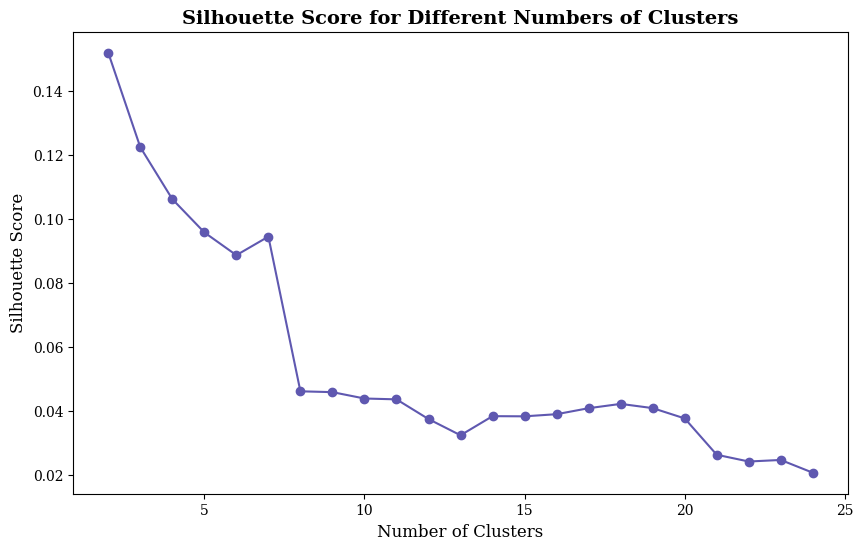

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o', color=line_color)
plt.title("Silhouette Score for Different Numbers of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

<a id="7"></a>
## Question 6

Cluster the 360 images using EM

In [36]:
pca = PCA(n_components=.90, random_state=RANDOM_STATE)
matrix_with_pca_embeddings_data = pca.fit_transform(DATA)
gm = GaussianMixture(n_components=3, random_state=RANDOM_STATE)

predicted = gm.fit_predict(matrix_with_pca_embeddings_data)

In [37]:
stat, p_value = pearsonr(encoded_labels, predicted)
print(stat, p_value)

-0.09444523763865151 0.07349527712288709


In [38]:
bic_scores = []
aic_scores = []

for n_components in cluster_range:
    gm = GaussianMixture(n_components=n_components, random_state=RANDOM_STATE)
    gm.fit(matrix_with_pca_embeddings_data)
    bic_scores.append(gm.bic(matrix_with_pca_embeddings_data))
    aic_scores.append(gm.aic(matrix_with_pca_embeddings_data))

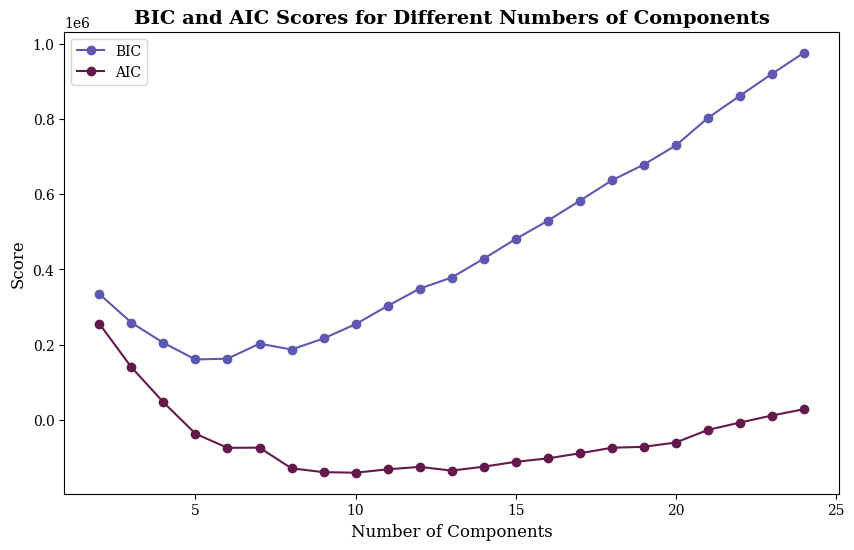

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, bic_scores, label='BIC', marker='o', color=COLOR_MAP(.3))
plt.plot(cluster_range, aic_scores, label='AIC', marker='o', color=COLOR_MAP(.6))
plt.title("BIC and AIC Scores for Different Numbers of Components")
plt.xlabel("Number of Components")
plt.ylabel("Score")
plt.legend()
plt.show()

#### Sampling Images from the Gaussian Distributions

sampling 20 random rocks

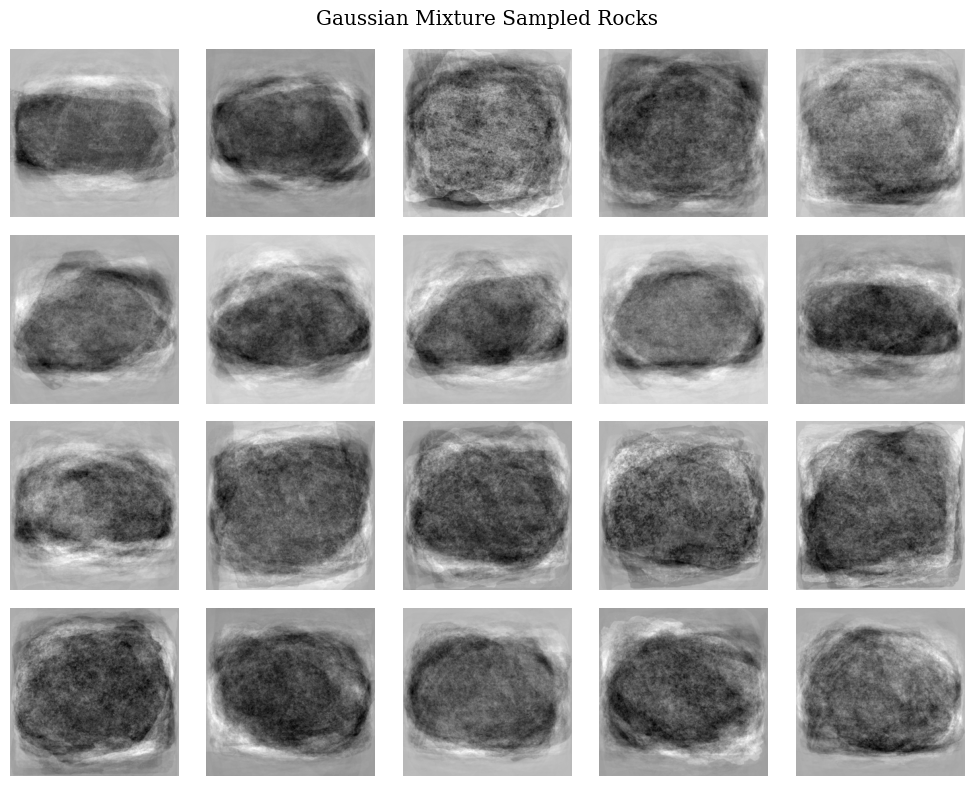

In [40]:
gm = GaussianMixture(n_components=6, random_state=RANDOM_STATE)
gm.fit(matrix_with_pca_embeddings_data)

samples, _ = gm.sample(n_samples=20)
original_space_samples = pca.inverse_transform(samples)

fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(np.array(original_space_samples[i, : ]).reshape((256, 256)), cmap = 'grey')
    ax.axis('off')
plt.suptitle("Gaussian Mixture Sampled Rocks")
plt.tight_layout()
plt.show()

Sampling 2 rocks from each cluster

In [41]:
n_samples_per_cluster = 2 
original_space_samples = []

for cluster_idx in range(gm.n_components):

    mean = gm.means_[cluster_idx]
    cov = gm.covariances_[cluster_idx]
    samples_from_cluster = np.random.multivariate_normal(mean, cov, n_samples_per_cluster)
    
    original_space_samples.extend(pca.inverse_transform(samples_from_cluster))

original_space_samples = np.array(original_space_samples)

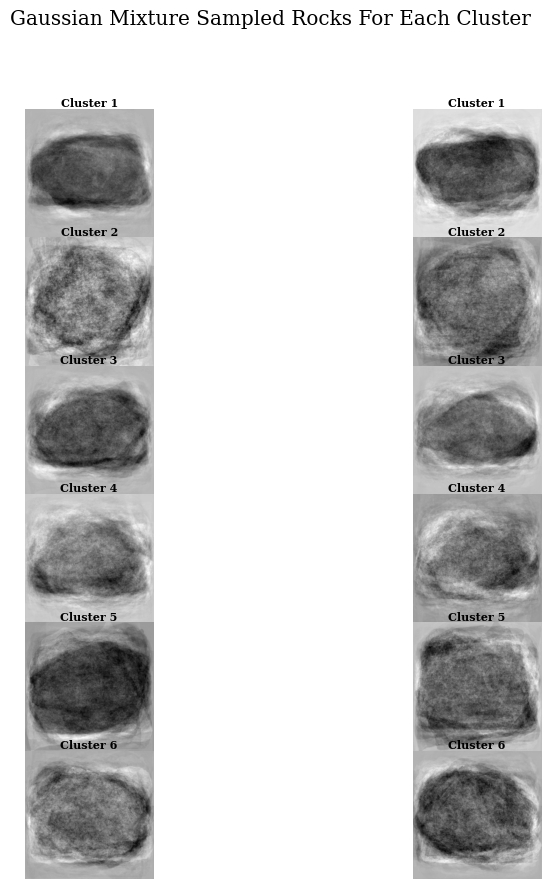

In [42]:
fig, axes = plt.subplots(gm.n_components, n_samples_per_cluster, figsize=(10, 10))
for i, ax in enumerate(axes.ravel()):
    cluster_label = i // n_samples_per_cluster
    ax.imshow(np.array(original_space_samples[i, :]).reshape((256, 256)), cmap='grey')
    ax.axis('off')
    ax.set_title(f"Cluster {cluster_label+1}", fontsize=8, pad=2)

plt.suptitle("Gaussian Mixture Sampled Rocks For Each Cluster")
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

<a id="8"></a>
## Question 7 
Build a feedforward neural network (using dense and/or CNN layers) with a few hidden layers (we suggest using Keras (within Tensorflow) or Pytorch). Train the network to classify on 360 rock images using rock name as the label - the category is indicated by the first letter in the filename (I, M and S). Use images from '120 Rocks' folder as your validation data. Choose the number of neurons you find appropriate and efficient (so you have enough time to run it), but make the last layer before the softmax should consist of 8 neurons. The hidden layers should have ReLU activation function. Train the network for multiple epochs until it converges (if the process is too slow, tweak the learning rate and consider simplifying your network). We will not deduct points based on the simplicity of your network, but we expect you to have performance that is above chance performance that could be obtained with an untrained network - in other words, we expect to see train and validation loss decrease and accuracy increase throughout the training

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary



In [80]:

VALIDATION_DATA, VALIDATION_LABELS = load_images_to_dataframe(VALIDATION_FOLDER)

rock_mapping = {"Igneous": 0, "Metamorphic": 1, "Sedimentary": 2}
val_encoded_labels = VALIDATION_LABELS.map(rock_mapping)




#### Converting Data

In [81]:
features = DATA.values
val_features = VALIDATION_DATA.values

print(len(features))
print(len(encoded_labels))

print(len(val_features))
print(len(val_encoded_labels))

360
360
120
120


In [83]:
batch_size = 16

In [84]:

features_tensor = torch.tensor(features, dtype=torch.float32) 
labels_tensor = torch.tensor(encoded_labels, dtype=torch.long) 

train_dataset = TensorDataset(features_tensor, labels_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [85]:
val_features_tensor = torch.tensor(val_features, dtype=torch.float32) 
val_labels_tensor = torch.tensor(val_encoded_labels, dtype=torch.long) 

val_dataset = TensorDataset(val_features_tensor, val_labels_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [86]:
print(f"Labels: {val_labels_tensor.unique()}")
print(f"Labels: {labels_tensor.unique()}")

Labels: tensor([0, 1, 2])
Labels: tensor([0, 1, 2])


In [87]:
print(val_dataset[0])

(tensor([1., 1., 1.,  ..., 1., 1., 1.]), tensor(2))


#### Building The Model

In [108]:
class RockClassifier(nn.Module):
    def __init__(self):
        super(RockClassifier, self).__init__()
        
        # Fully connected layers to process the flattened input
        self.fc1 = nn.Linear(256 * 256, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 8)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.output_layer = nn.Linear(8, 3)

    def forward(self, x):
        # Fully connected layers with ReLU
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.output_layer(x)
        return self.softmax(x) 
    


def train_model(model, Training_DataLoader, device, optimizer, criterion):
    model.train()
    train_correct, train_total, train_loss = 0, 0, 0
    
    for images, labels in Training_DataLoader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (torch.argmax(outputs, dim=1) == labels).sum().item()
        train_total += labels.size(0)
        

    return train_correct/train_total, train_loss

def eval_model(model, Test_DataLoader, device, criterion):
    model.eval()
    test_correct, test_total, test_loss = 0, 0, 0
    
    with torch.no_grad():
        for images, labels in Test_DataLoader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_loss += criterion(outputs, labels).item()
            test_correct+= (torch.argmax(outputs, dim=1) == labels).sum().item()
            test_total += labels.size(0)

    return test_correct/test_total, test_loss


In [109]:

model = RockClassifier()
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.01)  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



RockClassifier(
  (fc1): Linear(in_features=65536, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=8, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
  (output_layer): Linear(in_features=8, out_features=3, bias=True)
)

#### 7.A
Report Training Time

In [107]:
%time train_model(model, train_dataloader, device, optimizer, criterion)

Gradients for each parameter:
fc1.weight:
tensor([[ 4.8866e-05,  4.8866e-05,  4.8866e-05,  ...,  4.8866e-05,
          4.8866e-05,  4.8866e-05],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.7064e-04, -1.7064e-04, -1.7064e-04,  ..., -1.7064e-04,
         -1.7064e-04, -1.7064e-04],
        ...,
        [-5.1723e-05, -5.1723e-05, -5.1723e-05,  ..., -5.1723e-05,
         -5.1723e-05, -5.1723e-05],
        [-1.8613e-04, -1.8613e-04, -1.8613e-04,  ..., -1.8613e-04,
         -1.8613e-04, -1.8613e-04],
        [ 1.9929e-04,  1.9929e-04,  1.9929e-04,  ...,  1.9929e-04,
          1.9929e-04,  1.9929e-04]], device='cuda:0')
Gradients for each parameter:
fc1.weight:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:

(0.3333333333333333, 28.19179117679596)

#### 7.B 
Plot training and validation lost as a function of training epochs

In [91]:
num_epochs = 100

In [103]:

# Lists to store metrics for each epoch
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

for epoch in range(num_epochs):
    print(f"Current Epoch: {epoch+1}", end='\r')
    
    # Training
    train_accuracy, train_loss = train_model(model, train_dataloader, device, optimizer, criterion)
    training_accuracy.append(train_accuracy)
    training_loss.append(train_loss / len(train_dataloader))

    # Validation
    val_accuracy, val_loss = eval_model(model, val_dataloader, device, criterion)
    validation_accuracy.append(val_accuracy)
    validation_loss.append(val_loss/len(val_dataloader))



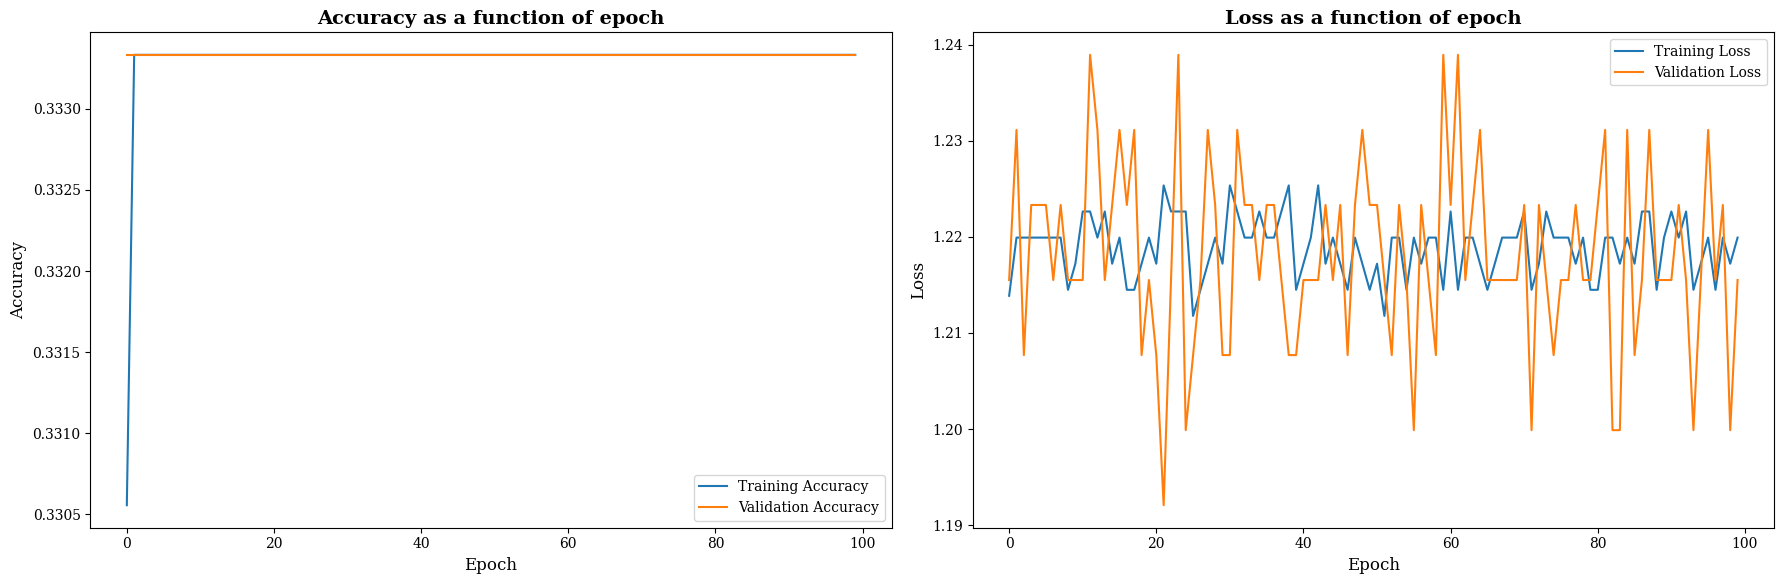

In [104]:
x = list(range(num_epochs))

fig, axs = plt.subplots(1, 2, figsize=(18, 6)) 

# Plot accuracy
axs[0].plot(x, training_accuracy, label='Training Accuracy')
axs[0].plot(x, validation_accuracy, label='Validation Accuracy')
axs[0].set_title('Accuracy as a function of epoch')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot loss
axs[1].plot(x, training_loss, label='Training Loss')
axs[1].plot(x, validation_loss, label='Validation Loss')
axs[1].set_title('Loss as a function of epoch')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

#### 7.C 

How many parameters does the network have? How many of those parameters are bias parameters?

Number of Weights and Biases per Layer

In [57]:

for name, param in model.named_parameters():
    if "weight" in name:
        print(f"Layer: {name} | Weights: {len(param.data)}")
    elif "bias" in name:
        print(f"Layer: {name} | Biases: {len(param.data)}")


Layer: fc1.weight | Weights: 512
Layer: fc1.bias | Biases: 512
Layer: fc2.weight | Weights: 256
Layer: fc2.bias | Biases: 256
Layer: fc3.weight | Weights: 8
Layer: fc3.bias | Biases: 8
Layer: output_layer.weight | Weights: 3
Layer: output_layer.bias | Biases: 3


Neural Network Architecture

In [58]:

summary(model, input_size=(batch_size, 256*256))

Layer (type:depth-idx)                   Output Shape              Param #
RockClassifier                           [16, 3]                   --
├─Linear: 1-1                            [16, 512]                 33,554,944
├─ReLU: 1-2                              [16, 512]                 --
├─Linear: 1-3                            [16, 256]                 131,328
├─ReLU: 1-4                              [16, 256]                 --
├─Linear: 1-5                            [16, 8]                   2,056
├─Linear: 1-6                            [16, 3]                   27
Total params: 33,688,355
Trainable params: 33,688,355
Non-trainable params: 0
Total mult-adds (M): 539.01
Input size (MB): 4.19
Forward/backward pass size (MB): 0.10
Params size (MB): 134.75
Estimated Total Size (MB): 139.05

#### 7.D

compare the activity of neurons in the next to the last layer (the one with 8 neurons) with the human data. (to get human data use mds_360.txt and mds_120.txt files). Similar to before, use Procrustes analysis to do the comparison.  For training and validation data (separately), report disparity and compute the correlation coefficient between each dimension of mtx1 and mtx2. Display results in a table. [3 points]

In [73]:
for i in model.output_layer.weight:
    print(len(i))

8
8
8
